In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mat

In [2]:
import platform

if platform.system() == 'Darwin':
    mat.rc('font', family='AppleGothic')
    mat.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv("dataTotal.csv")
df['탑승일자'] = pd.to_datetime(df['탑승일자'])

# 정상성 확인

## 자기상관성

In [43]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# ACF 계산 및 시각화 함수
def plot_acf(df, alpha=0.05, lags=40, threshold=0.2):
    variables = list(df.drop(labels='탑승일자', axis=1).columns)
    for var in variables:
        data = df[var].dropna()
        acf_result = acf(data, alpha=alpha, nlags=lags)
        acf_values = acf_result[0]

        # 그래프 생성
        plt.figure(figsize=(10, 5))
        plt.stem(range(len(acf_values)), acf_values, basefmt=" ", label="ACF")
        plt.axhline(0, color="black", linestyle="--", linewidth=0.8, label="Zero Line")
        plt.axhline(threshold, color="blue", linestyle="--", linewidth=1, label=f"Threshold (+{threshold})")
        plt.axhline(-threshold, color="blue", linestyle="--", linewidth=1, label=f"Threshold (-{threshold})")
        plt.title(f"{var}의 자기상관성")
        plt.xlabel("시차")
        plt.ylabel("자기상관")
        plt.legend()
        plt.show()

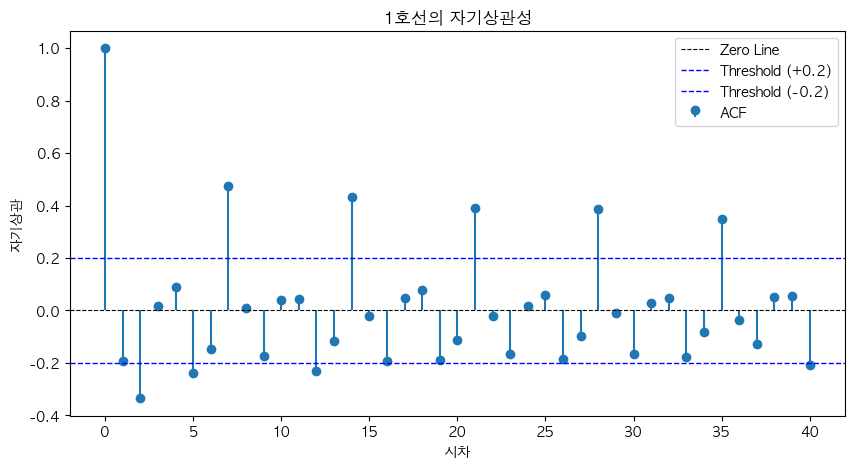

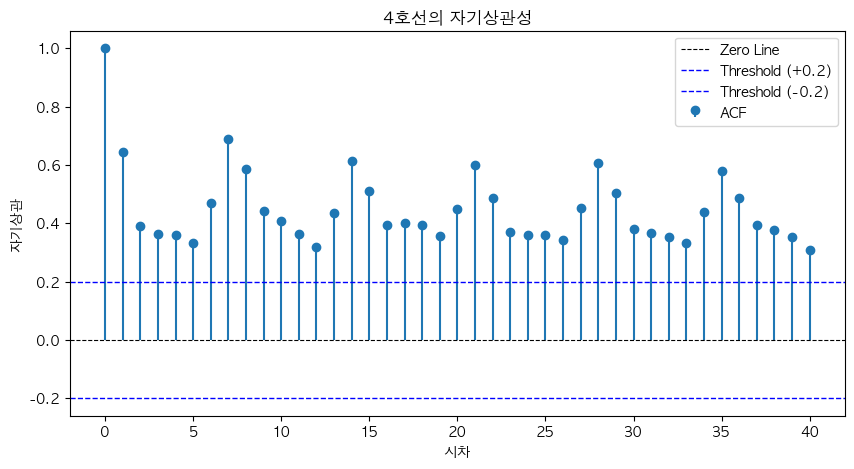

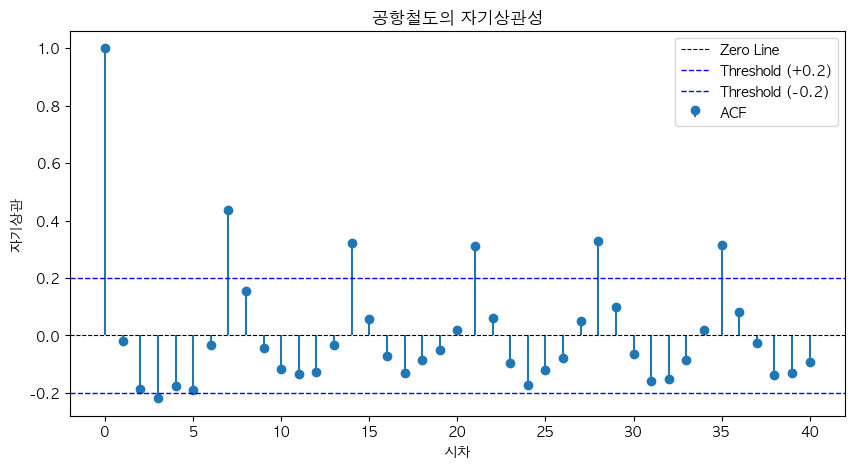

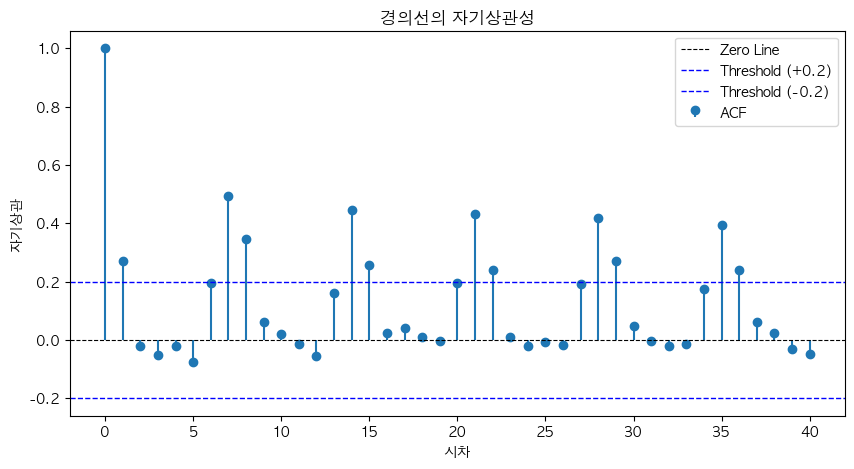

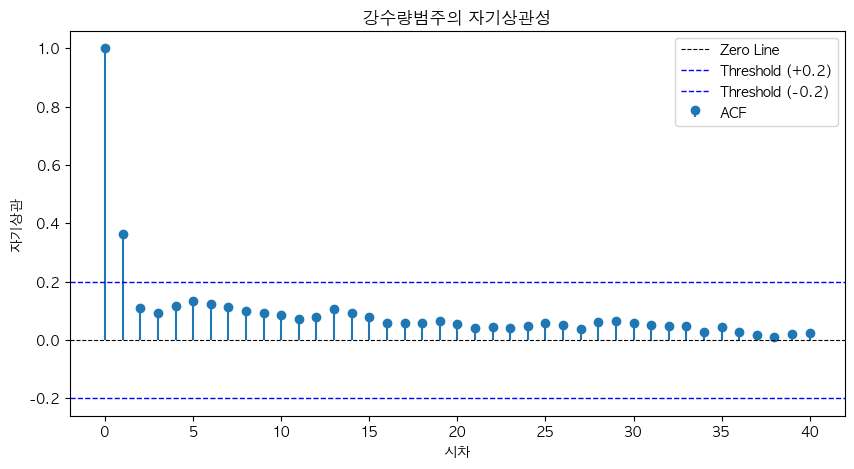

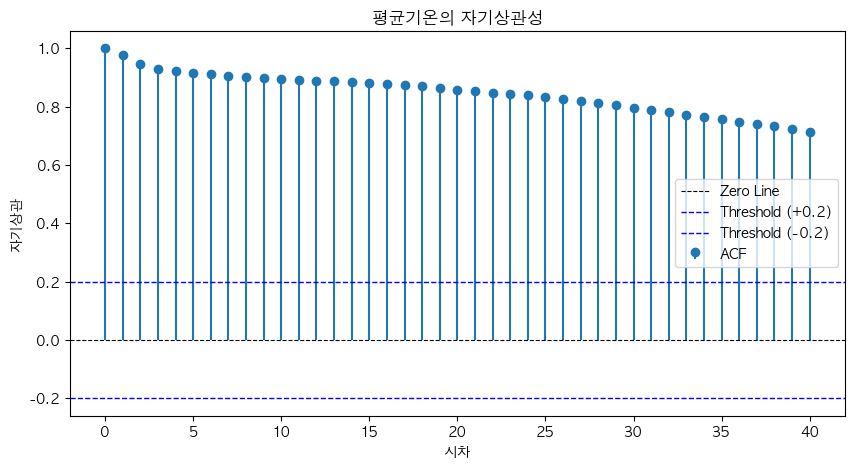

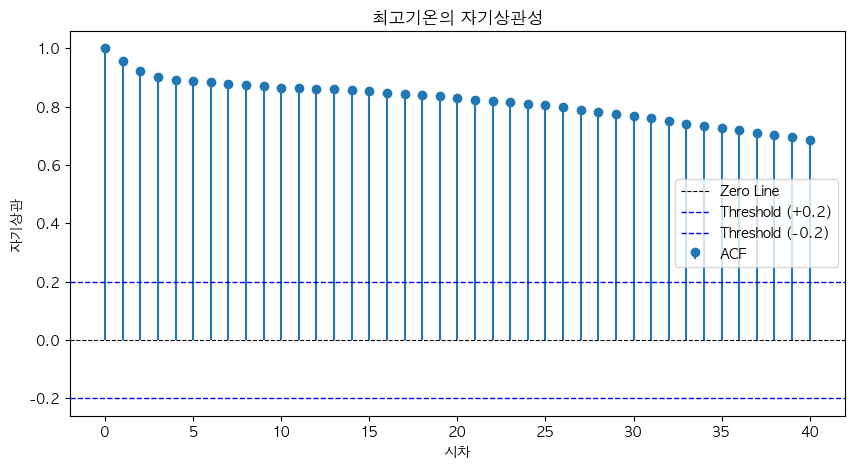

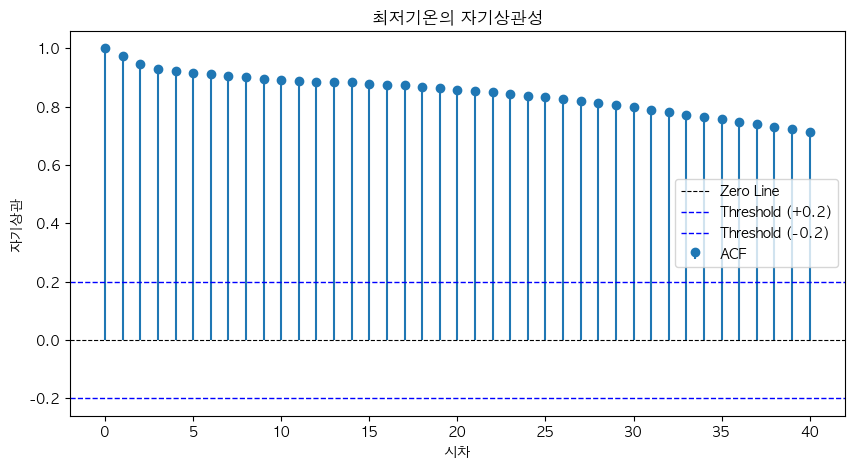

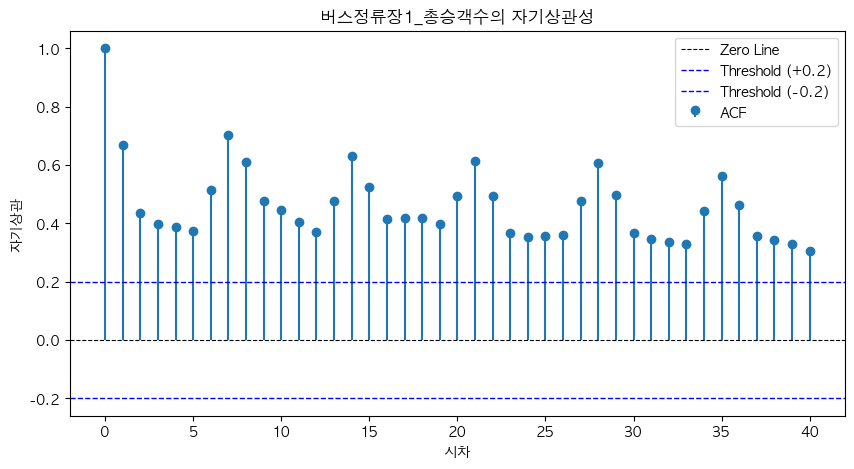

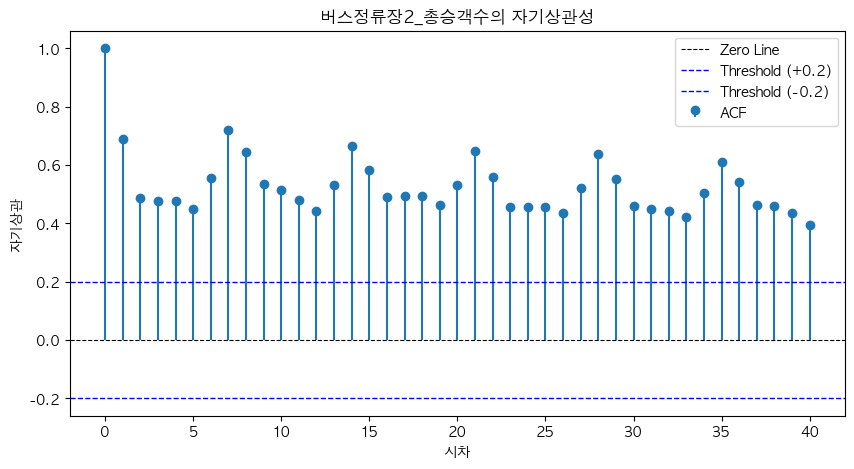

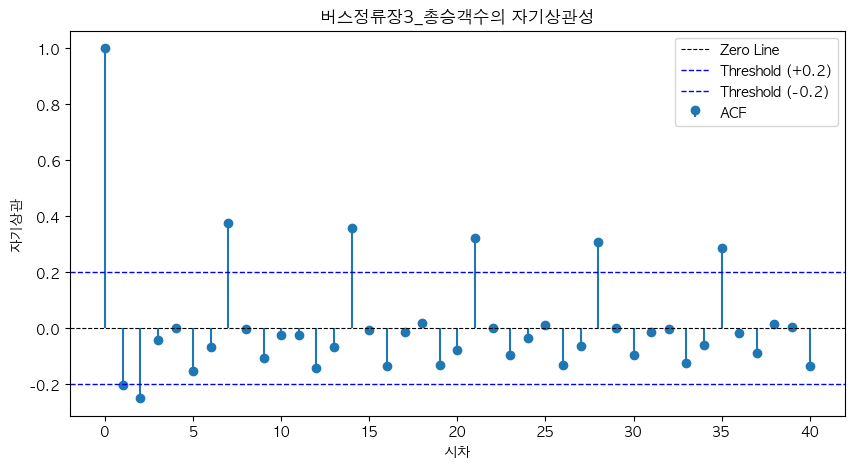

In [44]:
plot_acf(df)

## 단위근 검정

In [30]:
from statsmodels.tsa.stattools import adfuller

def check_stationary(df):
    cols = list(df.drop(labels='탑승일자', axis=1).columns)
    nonst_cnt = 0
    nonst_col = []

    for col in cols:
        result = adfuller(df[str(col)])
        if result[1] < 0.05:
            print(f"귀무가설 기각: df[{col}]은 정상성을 만족합니다.")
        else:
            nonst_cnt += 1
            nonst_col.append(col)
            print(f"귀무가설 채택: df[{col}]은 정상성을 만족하지 않습니다.")

    print(f"\n정상성 만족하지 않은 변수 : {nonst_cnt}개")
    print(f"{nonst_col}")
    return nonst_cnt, nonst_col

In [31]:
nonst_cnt, nonst_col = check_stationary(df)

귀무가설 기각: df[1호선]은 정상성을 만족합니다.
귀무가설 기각: df[4호선]은 정상성을 만족합니다.
귀무가설 기각: df[공항철도]은 정상성을 만족합니다.
귀무가설 기각: df[경의선]은 정상성을 만족합니다.
귀무가설 기각: df[강수량범주]은 정상성을 만족합니다.
귀무가설 기각: df[평균기온]은 정상성을 만족합니다.
귀무가설 기각: df[최고기온]은 정상성을 만족합니다.
귀무가설 기각: df[최저기온]은 정상성을 만족합니다.
귀무가설 기각: df[버스정류장1_총승객수]은 정상성을 만족합니다.
귀무가설 기각: df[버스정류장2_총승객수]은 정상성을 만족합니다.
귀무가설 기각: df[버스정류장3_총승객수]은 정상성을 만족합니다.

정상성 만족하지 않은 변수 : 0개
[]


In [32]:
for idx, col in enumerate(nonst_col):
    plt.figure(figsize=(12, 4))
    plt.plot(df['탑승일자'], df[col])
    plt.title(f"정상성 검사 : {col}")
    plt.show()
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [33]:
# 차분 적용
df_diff = df.copy()  # 원본 데이터프레임 유지
for col in nonst_col:
    df_diff[col] = df[col].diff()  # 1차 차분 적용

# 결과 확인 (NaN 제거)
df_diff = df_diff.dropna()  # 차분으로 생긴 첫 행의 NaN 제거

In [34]:
nonst_cnt, nonst_col = check_stationary(df_diff)

귀무가설 기각: df[1호선]은 정상성을 만족합니다.
귀무가설 기각: df[4호선]은 정상성을 만족합니다.
귀무가설 기각: df[공항철도]은 정상성을 만족합니다.
귀무가설 기각: df[경의선]은 정상성을 만족합니다.
귀무가설 기각: df[강수량범주]은 정상성을 만족합니다.
귀무가설 기각: df[평균기온]은 정상성을 만족합니다.
귀무가설 기각: df[최고기온]은 정상성을 만족합니다.
귀무가설 기각: df[최저기온]은 정상성을 만족합니다.
귀무가설 기각: df[버스정류장1_총승객수]은 정상성을 만족합니다.
귀무가설 기각: df[버스정류장2_총승객수]은 정상성을 만족합니다.
귀무가설 기각: df[버스정류장3_총승객수]은 정상성을 만족합니다.

정상성 만족하지 않은 변수 : 0개
[]


In [35]:
# 변수 다시 합치기
df = df_diff

# 성분분해

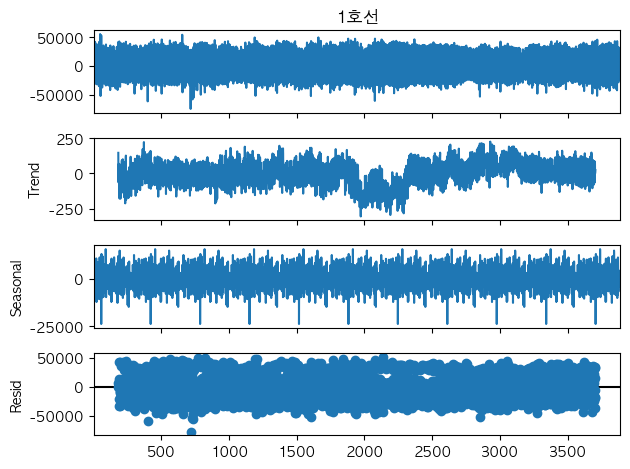

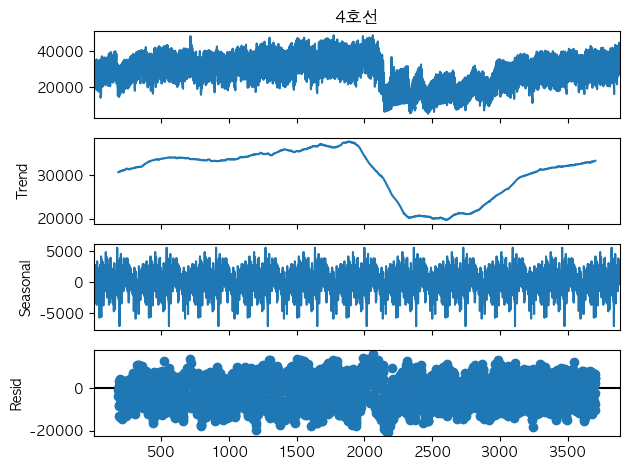

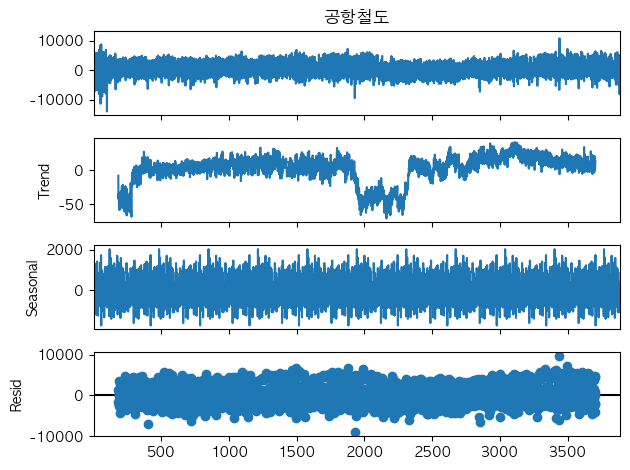

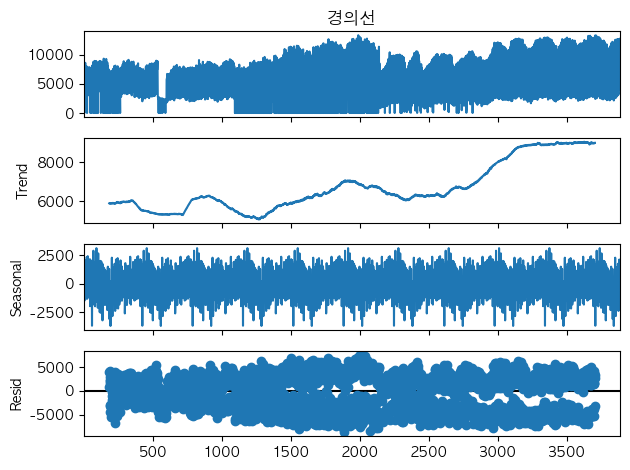

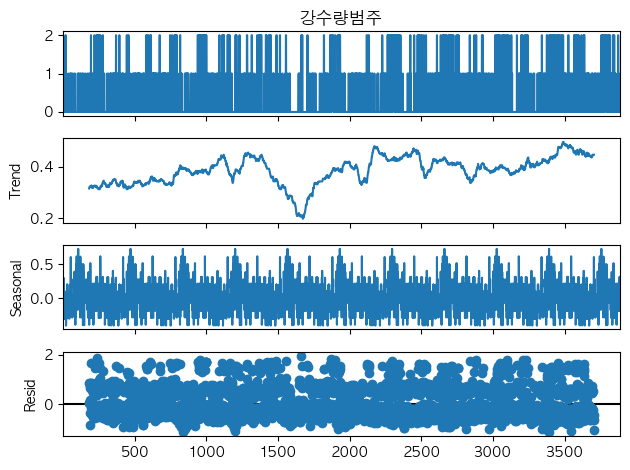

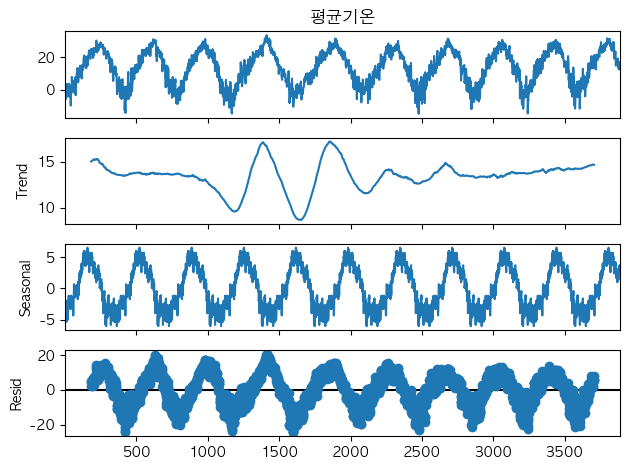

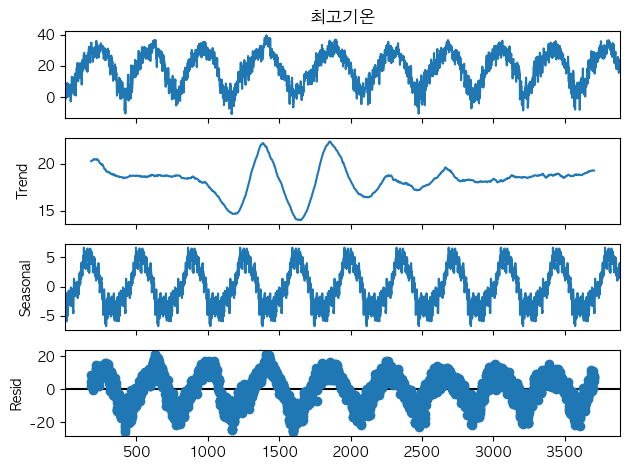

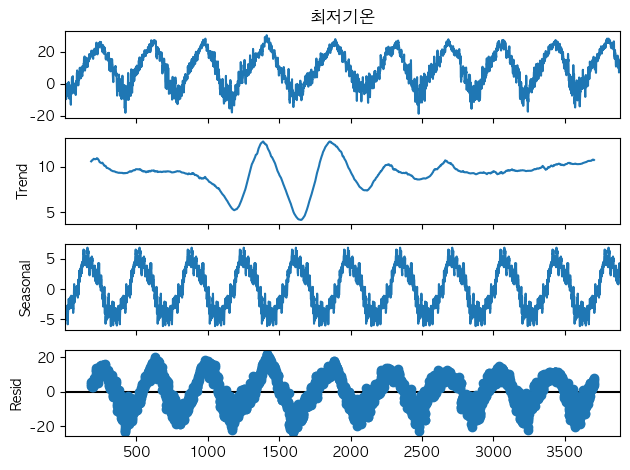

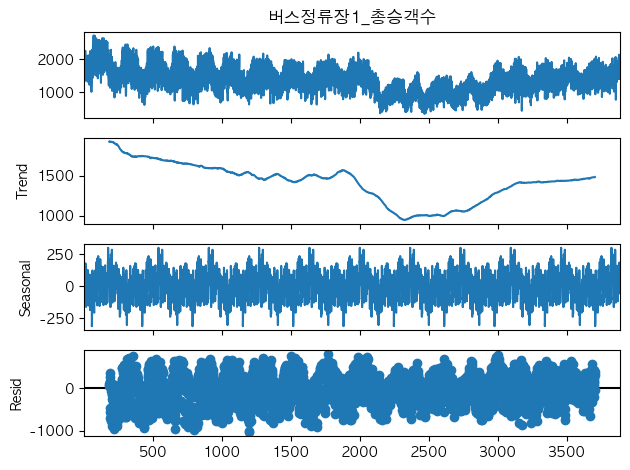

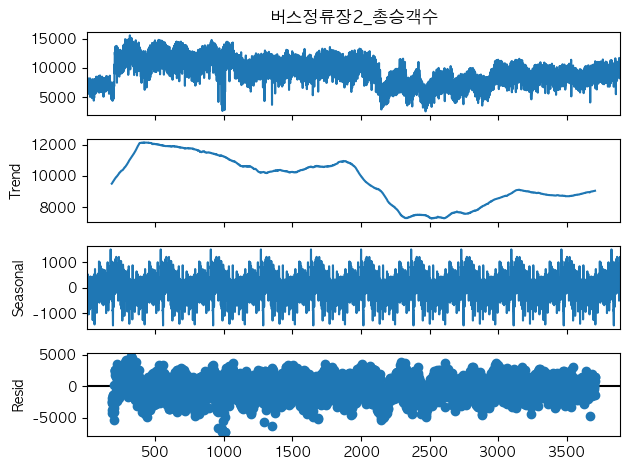

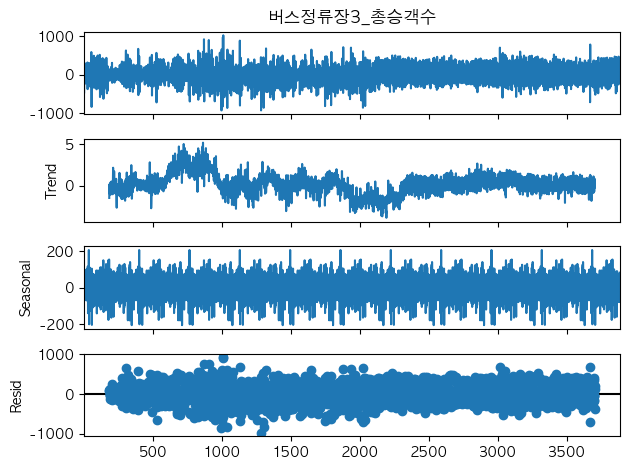

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 모든 변수에 대해 시계열 분해
def decompose_all_variables(df, columns, model_num, period):
    if model_num == 1: model = 'additive'
    elif model_num == 2: model = 'multiplicative'

    arr = []
    for col in columns:
        decomposed = seasonal_decompose(df[col], model=model, period=period)
        arr.append(decomposed)
    return arr

# 변수 리스트
columns = list(df.drop(labels='탑승일자', axis=1).columns)    # 시계열 변수들에서 제거함.
results = decompose_all_variables(df, columns, 1, 365)      # 주기를 365로 해야 계절성을 파악할 수 있다.

for idx, result in enumerate(results):
    result.plot()
plt.show()